# <center>Practical 09: Articulated Robots - Kinematics</center>

<p style="color:#0000FF";> <b>Let us first make sure that all the required dependencies are installed</b></p> 



## 1. Approach 1 - the single-step setup (applicable for both binder and local versions)
Run the following code block. Once everything is installed and there's no error, please run the code in section 1 and make sure the visualization works. If it does not work, please try the manual setup.

You might see a lot of warnings, but it will be ok as long as there are no errors.

In [ ]:
!pip install ansitable sympy==1.4 roboticstoolbox-python

## 2. Approach 2 - manual setup
### In your local machine (skip this if you are running the notebook on binder OR if the one-line setup works)
- If not already installed, install [Visual Studio Build Tools](https://visualstudio.microsoft.com/thank-you-downloading-visual-studio/?sku=BuildTools&rel=15). Select the options shown in the image below

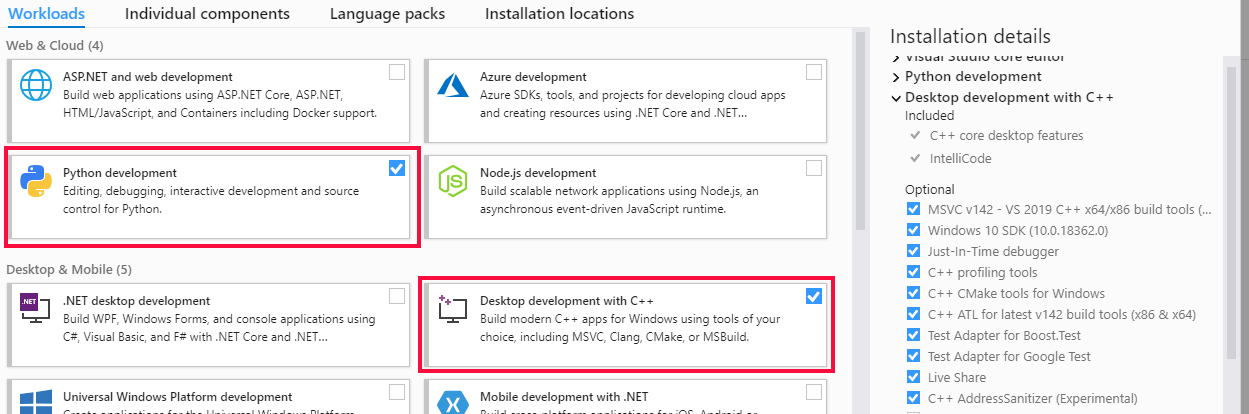

- After installing Visual Studio Build Tools, open File Explorer and go to the folder in which you cloned the Practicals repository. Go to Week09 and open your Support folder. An example path could be 'C:me\ECE4078\Week09\Support'.
- Right click in any blank space to bring up the menu, select ``Git Bash Here``
- Type ``git clone https://github.com/petercorke/robotics-toolbox-python.git``. This will clone the robotics toolbox folder to your Support folder.
- Open Anaconda command prompt 
    - on windows you can press your windows key to bring up the start menu, type anaconda command prompt. Bring your cursor to the item and right click. Select "Run as administrator".
    - on mac you can bring up your spotlight search and type navigator. Find Anaconda command prompt.
- In the command prompt, type ``cd `` (with a space) and type your full file path to your robotics toolbox folder (in your support folder). An example command would be ``cd C:me\ECE4078\Week09\Support\robotics-toolbox-python``.
- In the command prompt, type ``pip -V`` and make sure the end of the output contains (python 3.x). Make sure your python version is greater than or equal to 3.6. 
- In the command prompt, type ``pip install --upgrade pip setuptools`` if your pip version is correct. Otherwise, you might also try ``pip3 install --upgrade pip setuptools``
- In the command prompt, type ``pip install -e . `` or ``pip3 install -e . ``. 

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib notebook

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3
from spatialmath.base.transforms3d import tr2delta
import numpy as np
import math
import pickle

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from visualizer import *

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 5. Coding Exercise (7pts) : Inverse Kinematics

In this coding exercise, we will compute the sequence of joint configurations necessary to reach a desired end effector position using inverse kinematics. We will be using our 3dof manipulator

You are tasked with completing the following steps:
1. Compute end-effector transform using the current robot joint configuration ``robot.q`` by ``robot.fkine(.)``.
2. Compute error between target and the current positions of the end effector. We will use this position error to generate a velocity $\boldsymbol{\dot{X}}$ for the end-effector.
    - The attribute ``t`` of the variables ``current_ee`` and ``target`` gives you the position of the end effector and target in world coordinates
3. Compute the Jacobian at the current joint configuration. Use the function ``robot.jacob0(.)`` to get the Jacobian.
4. Compute the increment $\boldsymbol{\dot{q}}$. Since we are only considering the end effector position, we only need to compute the inverse of the linear velocity Jacobian. That is

\begin{equation}
\boldsymbol{\dot{q}} = J_{v, 3x3}^{-1} \boldsymbol{\dot{X}}
\end{equation}

5. Compute the new robot joint configuration using $\boldsymbol{\dot{q}}$, then update $\boldsymbol{q}$ and add it to *trajectory* using ``apend()``.
6. Update end-effector transform with updated joint positions.

Hint: Counsult https://petercorke.github.io/robotics-toolbox-python/index.html for methods such as ``fkine(.)`` and ``jacob0(.)``

### For your submission:
- Remove all print statements from your code
- Make sure that you do not change the signature of the ``inverse_kinematics`` function. Verify that your code returns the expected output (i.e. list of 1 x n np.arrays)
- Make sure that your notebook follows the naming convention: [Student_ID]_Practical09.ipynb

In [ ]:
def inverse_kinematics(robot, target, max_iterations=100, delta=0.1):
    """
    Compute sequence of joint configurations necessary to reach a desired end effector pose using inverse kinematics.
    :param robot (DHRobot): Robot object for which inverse kinematics will be computed
    :param target (SE3): Homogeneous transformation that describes desired position and orientation for the robot's end effector
    :param max_iterations (int): Max. number of inverse kinematics iterations
    :param delta (float): Update time step for integration
    
    :return List of 1xn arrays: Sequences joint configurations for robot with n joints
    """
    
    #TODO1: Get end-effector transform
    current_ee = robot.fkine(robot.q)
    
    # Initialize counter and variable to cumulate joint trajectory
    counter = 0
    trajectory = [robot.q]
    
    
    while counter < max_iterations:
        # Get current q
        q = robot.q
        
        #TODO 2: Get error between end-effector and target
        x_dot = target.t - current_ee.t 
        
        #TODO 3: Compute Jacobian
        J = robot.jacob0(q)
        
        #TODO 4: Compute increment
        dq = np.linalg.inv(J[:3,:3]) @ x_dot
        
        #TODO 5: Update q and append trajectory
        q_new = q + dq * delta
        trajectory.append(q_new)
        robot.q = q_new
        
        #TODO 6: Update end-effector transform
        current_ee = robot.fkine(robot.q)
        
        # Update counter
        counter += 1
    
    return trajectory  
    

### Test your implementation

For the target configuration ```SE3(1.37 , 0 , 1.37)``` and starting at configuration $\theta_1=0$, $\theta_2=90$, $\theta_3=-90$: 

- **Visually**: observe how our 3d-manipulator's end effector slowly approches the target
   - Hint: you could replace ``path_to_plot`` with ``seq_q`` in ``animate(.)`` and ``FuncAnimation`` for visulisation of example solution

- **Numerically**: compare the sequence of joints angles given by your method with the one provided in the test file ``Support/data/IK_TestCase.pk``: 

Please remove this and the following cell for submission

In [ ]:
# Load test case and define variables
with open('Support/data/IK_TestCase.pk', 'rb') as read_from:
    test_values = pickle.load(read_from)

seq_q = test_values['q_sequence']

# Initialising the robot parameters
link1 = RevoluteDH(d=0.8, a=0, alpha=np.pi/2)
link2 = RevoluteDH(d=0, a=0.8, alpha=0)
link3 = RevoluteDH(d=0, a=0.8, alpha=0)
my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')
# Define inital joint configuration and target end-effector position
my_bot.q = [0, np.pi/2, -np.pi/2]
target = SE3(1.37 , 0 , 1.37)

# Compute the sequence of joint configurations
path_to_plot = inverse_kinematics(my_bot, target)

# Visulisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)

my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
my_plot.draw()

def init():
    my_plot.draw()
    return
def animate(i):
    # replace the following two occurence of path_to_plot by seq_q to visulise the solution
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)

# Numerical comparison
print('Is computed path close to solution? ',np.all(np.isclose(path_to_plot, seq_q)))

In [ ]:
# # Load test case and define variables
# with open('Support/data/IK_TestCase.pk', 'rb') as read_from:
#     test_values = pickle.load(read_from)

# seq_q = test_values['q_sequence']

In [ ]:
# target = SE3(1.36337, 0.787144, 0.662268 )
# link1 = RevoluteDH(d=0.8, a=0, alpha=np.pi/2)
# link2 = RevoluteDH(d=0, a=0.8, alpha=0)
# link3 = RevoluteDH(d=0, a=0.8, alpha=0)

# my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')
# my_bot.q = [0, np.pi/2, -np.pi/4]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlim3d(-2.0, 2.0)
# ax.set_ylim3d(-2.0, 2.0)
# ax.set_zlim3d(0.0, 3.0)

# my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
# my_plot.draw()

# path_to_plot = inverse_kinematics(my_bot, target)

# def init():
#     my_plot.draw()
#     return

# def animate(i):
#     if i < len(path_to_plot):
#         my_bot.q = path_to_plot[i]
#         my_plot.draw()
#     return
    
# ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
#                               repeat=False)

In [ ]:
# import pickle

# results = {"target": target.t, "initial_q": [0, np.pi/2, -np.pi/4], "q_sequence": path_to_plot}

# with open('IK_q4.pk', 'wb') as write_to:
#     pickle.dump(results, write_to)

In [ ]:
# target = SE3(1.36337, 0.787144, 0.662268 )
# print(SE3(target.t))

In [ ]:
# -np.deg2rad(31.90)

In [ ]:
# import pickle
# with open('Otter/notebooks/IK_q5.pk', 'rb') as write_to:
#     data = pickle.load(write_to)
#     print(data)